# Data preparation and extraction

In [0]:
!apt-get install p7zip-full

In [0]:
!7z x /content/colab_drive/colab_data/sat/test.tar.7z

In [0]:
!tar -xvf /content/colab_drive/colab_data/sat/test.tar

In [0]:
!tar -xvf /content/colab_drive/colab_data/sat/train.tar

In [0]:
!ls /content/colab_drive/colab_data/sat/

64.h5  test.tar  train	train-jpg  train.tar


# Confirming GPU is connected

In [0]:
torch.cuda.is_available()

True

In [0]:
torch.backends.cudnn.enabled

True

# Building the CNN model

In [0]:
# Import the deep learning libraries

import sys
import torch
from fastai.imports import*
from fastai.transforms import*
from fastai.conv_learner import*
from fastai.model import*
from fastai.dataset import*
from fastai.sgdr import*
from fastai.plots import*

In [0]:
PATH = "/content/"

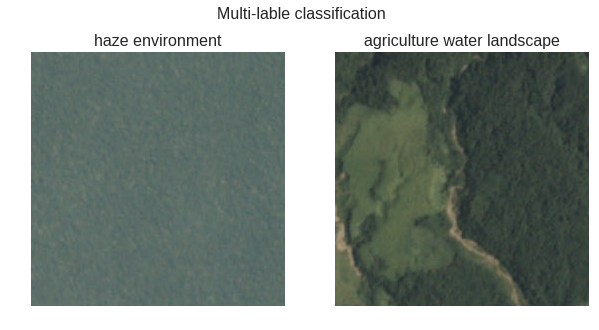

In [0]:
# Sample data visualization

list_paths = [f"{PATH}train-jpg/train_0.jpg", f"{PATH}train-jpg/train_1.jpg"]
titles = ["haze environment", "agriculture water landscape"]
plots_from_files(list_paths, titles = titles, maintitle = "Multi-lable classification")

In [0]:
from sklearn.metrics import fbeta_score
import warnings

In [0]:
def f2(preds, targs, start=0.17, end=0.24, step=0.01):
    with warnings.catch_warnings():
        warnings.simplefilter("ignore")
        return max([fbeta_score(targs, (preds>th), 2, average='samples')
                    for th in np.arange(start,end,step)])

In [0]:
train_metrics = [f2]

In [0]:
base_model = resnet34

In [0]:
label_csv = f'{PATH}train_v2.csv'
n = len(list(open(label_csv))) - 1
val_idxs = get_cv_idxs(n)

In [0]:
# Data transformation to improve the model

def get_data(size):
  tfms = tfms_from_model(base_model, size, aug_tfms=transforms_top_down, max_zoom=1.06)
  return ImageClassifierData.from_csv(PATH, 'train-jpg', label_csv, tfms=tfms, 
                                     suffix='.jpg', val_idxs=val_idxs, test_name='test-jpg')

In [0]:
data = get_data(256)

In [0]:
x, y = next(iter(data.val_dl))

In [0]:
y


    1     0     0  ...      0     0     1
    0     0     0  ...      0     0     0
    1     0     0  ...      0     0     0
       ...          ⋱          ...       
    1     0     0  ...      0     0     1
    0     0     0  ...      0     0     0
    0     0     0  ...      0     0     1
[torch.cuda.FloatTensor of size 64x17 (GPU 0)]

In [0]:
# Listing the multiple lables

list(zip(data.classes, y[0]))

[('agriculture', 1.0),
 ('artisinal_mine', 0.0),
 ('bare_ground', 0.0),
 ('blooming', 0.0),
 ('blow_down', 0.0),
 ('clear', 1.0),
 ('cloudy', 0.0),
 ('conventional_mine', 0.0),
 ('cultivation', 0.0),
 ('habitation', 0.0),
 ('haze', 0.0),
 ('partly_cloudy', 0.0),
 ('primary', 1.0),
 ('road', 0.0),
 ('selective_logging', 0.0),
 ('slash_burn', 0.0),
 ('water', 1.0)]

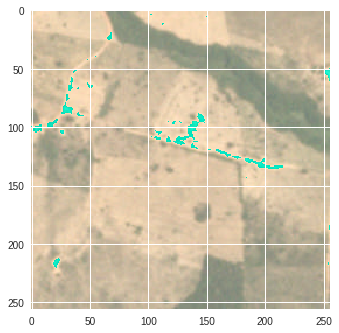

In [0]:
plt.imshow(data.val_ds.denorm(to_np(x))[2]*1.4);

In [0]:
# Resize the image for the base model

size = 64
data = get_data(size)
data = data.resize(int(size*1.3), 'content/temp')

In [0]:
os.makedirs('content/models', exist_ok=True)

In [0]:
os.makedirs('content/temp', exist_ok=True)

In [0]:
learn = ConvLearner.pretrained(base_model, data, metrics=train_metrics)

Downloading: "https://download.pytorch.org/models/resnet34-333f7ec4.pth" to /content/.torch/models/resnet34-333f7ec4.pth
100%|██████████| 87306240/87306240 [00:03<00:00, 27727323.55it/s]


In [0]:
# List some neural network layers

list(learn.summary().items())[:6]

[('Conv2d-1',
  OrderedDict([('input_shape', [-1, 3, 64, 64]),
               ('output_shape', [-1, 64, 32, 32]),
               ('trainable', False),
               ('nb_params', 9408)])),
 ('BatchNorm2d-2',
  OrderedDict([('input_shape', [-1, 64, 32, 32]),
               ('output_shape', [-1, 64, 32, 32]),
               ('trainable', False),
               ('nb_params', 128)])),
 ('ReLU-3',
  OrderedDict([('input_shape', [-1, 64, 32, 32]),
               ('output_shape', [-1, 64, 32, 32]),
               ('nb_params', 0)])),
 ('MaxPool2d-4',
  OrderedDict([('input_shape', [-1, 64, 32, 32]),
               ('output_shape', [-1, 64, 16, 16]),
               ('nb_params', 0)])),
 ('Conv2d-5',
  OrderedDict([('input_shape', [-1, 64, 16, 16]),
               ('output_shape', [-1, 64, 16, 16]),
               ('trainable', False),
               ('nb_params', 36864)])),
 ('BatchNorm2d-6',
  OrderedDict([('input_shape', [-1, 64, 16, 16]),
               ('output_shape', [-1, 64, 16, 16]),


epoch      trn_loss   val_loss   f2         
    0      0.220318   0.274464   0.805284  



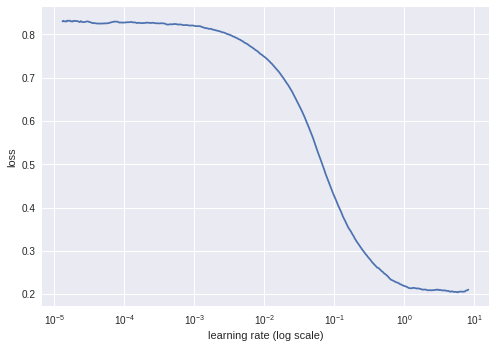

In [0]:
learn_rate_finder=learn.lr_find()
learn.sched.plot()

In [0]:
learn_rate = 0.2

In [0]:
# First training iteration

learn.fit(learn_rate, 3, cycle_len=1, cycle_mult=2)

epoch      trn_loss   val_loss   f2         
    0      0.145007   0.134308   0.879388  
 39%|███▊      | 196/506 [00:25<00:40,  7.70it/s, loss=0.147]

    1      0.145664   0.13014    0.882454  
 81%|████████  | 408/506 [00:48<00:11,  8.37it/s, loss=0.136]

    2      0.140796   0.127261   0.887525  
    3      0.140551   0.127274   0.887906  
  3%|▎         | 16/506 [00:03<01:48,  4.52it/s, loss=0.139]

    4      0.135549   0.125174   0.889159  
 60%|██████    | 304/506 [00:36<00:23,  8.42it/s, loss=0.132]

    5      0.131675   0.123081   0.893049  
 91%|█████████ | 458/506 [00:54<00:05,  8.34it/s, loss=0.129]

    6      0.128944   0.122914   0.892557  



[array([0.12291]), 0.8925571860214081]

In [0]:
early_lr = np.array([learn_rate/9, learn_rate/3, learn_rate])

In [0]:
learn.unfreeze()

In [0]:
learn.fit(early_lr, 3, cycle_len=1, cycle_mult=2)

epoch      trn_loss   val_loss   f2         
    0      0.121627   0.111077   0.907456  
 25%|██▌       | 128/506 [00:28<01:24,  4.48it/s, loss=0.124]

    1      0.115909   0.105253   0.91242   
 51%|█████     | 257/506 [00:57<00:55,  4.49it/s, loss=0.109]

    2      0.110268   0.101162   0.915603  
 66%|██████▌   | 332/506 [01:12<00:38,  4.55it/s, loss=0.114]

    3      0.111875   0.103902   0.91193   
 74%|███████▍  | 376/506 [01:20<00:27,  4.64it/s, loss=0.108]

    4      0.108481   0.101881   0.913865  
 79%|███████▉  | 401/506 [01:24<00:22,  4.74it/s, loss=0.104]

    5      0.104054   0.099173   0.914645  
 82%|████████▏ | 414/506 [01:30<00:20,  4.58it/s, loss=0.101]

    6      0.096986   0.097443   0.917393  



[array([0.09744]), 0.9173925354567338]

In [0]:
# Second training iteration

size = 128
learn_rate = 0.2

In [0]:
learn.set_data(get_data(size))
learn.freeze()
learn.fit(learn_rate, 3, cycle_len=1, cycle_mult=2)

epoch      trn_loss   val_loss   f2         
    0      0.09996    0.097212   0.916267  
 25%|██▌       | 128/506 [00:31<01:32,  4.08it/s, loss=0.0982]

    1      0.101061   0.096214   0.916733  
 50%|█████     | 253/506 [01:01<01:01,  4.12it/s, loss=0.0959]

    2      0.097016   0.095355   0.916988  
 64%|██████▍   | 324/506 [01:18<00:44,  4.11it/s, loss=0.098] 

    3      0.097754   0.094996   0.917953  
 72%|███████▏  | 366/506 [01:27<00:33,  4.17it/s, loss=0.0966]

    4      0.096139   0.094025   0.918117  
 77%|███████▋  | 390/506 [01:33<00:27,  4.16it/s, loss=0.0953]

    5      0.094042   0.093558   0.919587  
 80%|███████▉  | 404/506 [01:37<00:24,  4.13it/s, loss=0.0958]

    6      0.095383   0.093565   0.919398  



[array([0.09356]), 0.9193983561228077]

In [0]:
learn.unfreeze()

In [0]:
learn.fit(early_lr, 3, cycle_len=1, cycle_mult=2)

epoch      trn_loss   val_loss   f2         
    0      0.092885   0.088266   0.926309  
 25%|██▍       | 125/506 [01:10<03:36,  1.76it/s, loss=0.0984]

    1      0.094203   0.087961   0.926152  
 49%|████▉     | 249/506 [02:20<02:24,  1.78it/s, loss=0.0899]

    2      0.09099    0.08695    0.927488  
 64%|██████▎   | 322/506 [02:59<01:42,  1.79it/s, loss=0.0952]

    3      0.092775   0.089351   0.924189  
 72%|███████▏  | 364/506 [03:23<01:19,  1.79it/s, loss=0.0929]

    4      0.090079   0.086668   0.926225  
 77%|███████▋  | 389/506 [03:35<01:04,  1.80it/s, loss=0.0842]

    5      0.085556   0.086119   0.927511  
 80%|███████▉  | 404/506 [03:45<00:56,  1.80it/s, loss=0.086]

    6      0.082297   0.084952   0.928449  



[array([0.08495]), 0.9284489690233286]

In [0]:
learn.save(f'/content/colab_drive/colab_data/sat/{size}')

In [0]:
# Third training iteration

size = 256

In [0]:
learn.set_data(get_data(size))
learn.freeze()
learn.fit(learn_rate, 3, cycle_len=1, cycle_mult=2)

epoch      trn_loss   val_loss   f2         
    0      0.08977    0.089318   0.924519  
 25%|██▍       | 124/506 [01:19<04:04,  1.56it/s, loss=0.0919]

    1      0.088416   0.088688   0.925436  
 49%|████▉     | 248/506 [02:36<02:43,  1.58it/s, loss=0.087]

    2      0.087389   0.088155   0.925987  
 63%|██████▎   | 321/506 [03:21<01:56,  1.59it/s, loss=0.0871]

    3      0.092102   0.088379   0.924991  
 72%|███████▏  | 364/506 [03:49<01:29,  1.59it/s, loss=0.0882]

    4      0.089325   0.087756   0.926403  
 77%|███████▋  | 389/506 [04:01<01:12,  1.61it/s, loss=0.0875]

    5      0.086943   0.087264   0.927045  
 80%|███████▉  | 404/506 [04:12<01:03,  1.60it/s, loss=0.088]

    6      0.087643   0.087433   0.926585  



[array([0.08743]), 0.9265850283289306]

In [0]:
learn.save(f'/content/colab_drive/colab_data/sat/{size}a')

In [0]:
learn.unfreeze()
learn.fit(early_lr, 3, cycle_len=1, cycle_mult=2)

epoch      trn_loss   val_loss   f2         
    0      0.084509   0.083504   0.930677  
 25%|██▍       | 124/506 [03:35<11:03,  1.74s/it, loss=0.0873]

    1      0.087259   0.083985   0.92981   
 49%|████▉     | 248/506 [07:10<07:27,  1.74s/it, loss=0.0852]

    2      0.082675   0.082325   0.932448  
 63%|██████▎   | 321/506 [09:15<05:19,  1.73s/it, loss=0.0915]

    3      0.087613   0.085021   0.930419  
 72%|███████▏  | 364/506 [10:27<04:04,  1.72s/it, loss=0.0839]

    4      0.087907   0.082379   0.930528  
 77%|███████▋  | 389/506 [11:07<03:20,  1.72s/it, loss=0.0836]

    5      0.077738   0.081859   0.931836  
 80%|███████▉  | 403/506 [11:34<02:57,  1.72s/it, loss=0.0786]

    6      0.079663   0.081668   0.932603  



[array([0.08167]), 0.9326025904770081]

In [0]:
# Average accuracy of the final model

multi_preds, y = learn.TTA()
preds = np.mean(multi_preds, 0)
f2(preds, y)

0.9313199401378716